In [2]:
import glob
import pandas as pd
import os

In [3]:
def feature_counts(directory):
    fn = directory+ '/feature_names.txt'
    with open(fn) as f:
        lines = f.readlines()
        keep = int(lines[1].split('\t')[1])
        remove = int(lines[2].split('\t')[1])
    return keep, remove

In [4]:
def load_majority_vote(exp_path):
    fn = exp_path+'/majority_vote.csv'
    res = pd.read_csv(fn)
    return res

def load_roadnet(exp_path):
    fselects = ['None', 'rfecv_linsvc', 'mrmr']
    res = []
    for selection_type in fselects:
        exp_param_path = '%s/%s#%s' %(exp_path, 'RoadNet', selection_type)
        fn = '%s/cv_5_best_models_evaluation.csv' %(exp_param_path)
        cv_res = pd.read_csv(fn)
        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
        cv_res['feature_select'] = selection_type
        cv_res['scale'] = 'min-max'
        cv_res['feature'] = 'RoadNet'
        keep, remove = feature_counts(exp_param_path)
        cv_res['# ftr keep'] = keep
        cv_res['# ftr remove'] = remove
        res.append(cv_res)
    res = pd.concat(res)
    return res 

def load_else(exp_path):
    
    totals = ['NO_TOTAL', 'TOTAL']
    years_choices = ['~2014', '~2016']
    feature_types = ['Segment', 'RoadNet+Segment']
    res = []
    for total_or_not in totals:
        for year in years_choices:
            for ftr_type in feature_types:
                for max_cut in (True, False,):
                    for selection_type in ['None', 'rfecv_linsvc', 'mrmr']:
                        scale_type = 'max-cutoff' if max_cut else 'min-max'
                        exp_param = '#'.join([ftr_type, total_or_not, year, scale_type, selection_type])
                        fn = '%s/%s/cv_5_best_models_evaluation.csv' % (exp_path, exp_param)
                        cv_res = pd.read_csv(fn)
                        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
                        cv_res['feature_select'] = selection_type
                        cv_res['scale'] = scale_type
                        cv_res['feature'] = ftr_type
                        cv_res['time period'] = year
                        cv_res['total or by type'] = total_or_not
                        keep, remove = feature_counts('%s/%s' % (exp_path, exp_param))
                        cv_res['# ftr keep'] = keep
                        cv_res['# ftr remove'] = remove
                        res.append(cv_res)
    res = pd.concat(res)

    return res 

def load_one_run(seed):
    exp_path = 'data/csl_experiment/seed_%d' % seed
    major = load_majority_vote(exp_path)
    roadnet = load_roadnet(exp_path)
    res_else = load_else(exp_path)
    res = pd.concat([major, roadnet, res_else], ignore_index=True)
    res['seed'] = seed
    return res

In [5]:
def load_all_run():
    all_run = []
    for seed in [0, 100, 972, 5258, 7821, 40918, 57852, 168352, 291592, 789729423]:
        one_run_res = load_one_run(seed)
        all_run.append(one_run_res)
    all_run_res = pd.concat(all_run, ignore_index=True)
    all_run_res.fillna('', inplace=True)
    all_run_res['key'] = all_run_res.apply(lambda x: '%s %s %s %s %s %s'.strip() % (x['feature'], x['total or by type'], x['time period'], x['model'], x['scale'], x['feature_select']), axis=1)        
    return all_run_res

In [6]:
all_run_res = load_all_run()

In [7]:
all_run_res.sort_values('test_f1_micro', ascending=False).head(3)

,# ftr keep,# ftr remove,feature,feature_select,kind,model,scale,test_acc,test_f1_macro,test_f1_micro,...,test_mse,time period,total or by type,train_acc,train_f1_macro,train_f1_micro,train_f1_weighted,train_mse,seed,key
401,116,0,Segment,mrmr,cls,GDBcls,min-max,0.698413,0.375187,0.698413,...,0.444444,~2016,NO_TOTAL,1,1,1,1,0,0,Segment NO_TOTAL ~2016 GDBcls min-max mrmr
5045,65,0,RoadNet+Segment,None,cls,GDBcls,min-max,0.698413,0.464153,0.698413,...,0.444444,~2016,TOTAL,1,1,1,1,0,7821,RoadNet+Segment TOTAL ~2016 GDBcls min-max None
5025,65,0,RoadNet+Segment,mrmr,cls,BAGcls,max-cutoff,0.698413,0.522222,0.698413,...,0.539683,~2016,TOTAL,1,1,1,1,0,7821,RoadNet+Segment TOTAL ~2016 BAGcls max-cutoff ...


In [8]:
all_run_res[all_run_res.key == 'Segment NO_TOTAL ~2016 GDBcls min-max mrmr'][['test_f1_weighted', 'test_f1_micro', 'test_f1_macro']]

,test_f1_weighted,test_f1_micro,test_f1_macro
401,0.658908,0.698413,0.375187
1426,0.367130,0.428571,0.200787
2453,0.383845,0.412698,0.215333
3465,0.368334,0.412698,0.220808
4486,0.507003,0.571429,0.259104
5514,0.376000,0.412698,0.229961
6542,0.331884,0.365079,0.193376
7550,0.526593,0.555556,0.329310
8585,0.291156,0.349206,0.154586
9590,0.568001,0.603175,0.373633


In [10]:
clean_res = all_run_res.drop(['feature', 'total or by type', 'time period', 'model', 'scale', 'feature_select',
                  'kind', '# ftr remove', '# ftr keep', 
                  'train_acc', 'train_f1_macro', 'train_f1_micro', 'train_f1_weighted', 'train_mse',
                  'test_acc', 'test_mse',
                  'seed',
                 ], axis=1)

In [11]:
means = clean_res.groupby('key').mean().sort_values('test_f1_weighted', ascending=False)

In [17]:
stds = clean_res.groupby('key').std()

In [13]:
%matplotlib inline

In [32]:
means_to_plot = means.head(3)
index_to_plot = means_to_plot.index

stds_to_plot = stds.loc[index_to_plot]
stds_to_plot

,test_f1_macro,test_f1_micro,test_f1_weighted
key,,,
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff mrmr,0.047795,0.052378,0.053995
RoadNet+Segment TOTAL ~2016 RFcls max-cutoff None,0.037072,0.060350,0.062776
RoadNet+Segment TOTAL ~2014 BAGcls max-cutoff mrmr,0.069428,0.062155,0.063581


In [37]:
means_to_plot

,test_f1_macro,test_f1_micro,test_f1_weighted
key,,,
RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff mrmr,0.318461,0.555556,0.522244
RoadNet+Segment TOTAL ~2016 RFcls max-cutoff None,0.306816,0.550794,0.521277
RoadNet+Segment TOTAL ~2014 BAGcls max-cutoff mrmr,0.332528,0.539683,0.518214


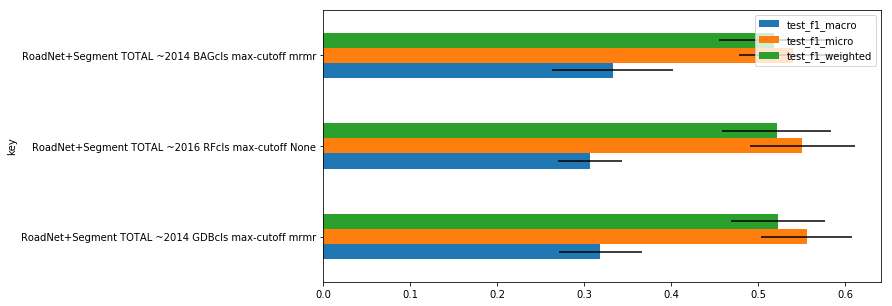

In [36]:
means_to_plot.plot(kind='barh', xerr=stds_to_plot, figsize=(10,5))

In [33]:
clean_res[clean_res.key.isin(index_to_plot[:1])]

,test_f1_macro,test_f1_micro,test_f1_weighted,key
707,0.312994,0.619048,0.590639,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
1723,0.329147,0.476190,0.458477,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
2744,0.316695,0.571429,0.551029,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
3774,0.290438,0.507937,0.476017,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
4787,0.439818,0.650794,0.616350,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
5808,0.330880,0.571429,0.537587,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
6832,0.264004,0.507937,0.455709,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
7853,0.296735,0.539683,0.526903,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
8869,0.282423,0.555556,0.490979,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
9891,0.321478,0.555556,0.518747,RoadNet+Segment TOTAL ~2014 GDBcls max-cutoff ...
